In [1]:
import matplotlib.pyplot as plt
from numpy import inf
from utils import *
from classifiers.MultivariateGaussianClassifier import *
from classifiers.NaiveBayesClassifier import *
from classifiers.TiedCovarianceGaussianClassifier import *
from classifiers.TiedDiagCovGaussianClassifier import *
from classifiers.LogisticRegression import *
from classifiers.LinearSVM import *
from classifiers.KernelSVM import *
from classifiers.GaussianMixtureModel import *
from transformers.PCA import *
from transformers.Gaussianizer import *
from tabulate import tabulate
import concurrent.futures
from tqdm import tqdm


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
DTR, LTR = load_data('./data/Train.txt')

In [3]:
print_plots = False
load_precomputed_data = [
    True,  # Dataset Gaussianized
    True,  # Gaussian models
    True,  # Logistic Regression
    True,  # Logistic Regression - lamb = 0
    True,  # Linear SVM - C estimation
    True,  # Linear SVM - C = 1e-3
    True,  # Quadratic kernel SVM
    True,  # Quadratic kernel SVM - log(C) = -3
    True,  # RBF kernel SVM
    True,  # RBF kernel SVM - log(γ) = -4, log(C) = 2
    True,  # GMM
]
store_computed_data = [
    True,  # Dataset Gaussianized
    True,  # Gaussian models
    True,  # Logistic Regression
    True,  # Logistic Regression - lamb = 0
    True,  # Linear SVM - C estimation
    True,  # Linear SVM - C = 1e-3
    True,  # Quadratic kernel SVM
    True,  # Quadratic kernel SVM - log(C) = -3
    True,  # RBF kernel SVM
    True,  # RBF kernel SVM - log(γ) = -4, log(C) = 2
    True,  # GMM
]

In [4]:
if load_precomputed_data[0]:
    DTR_G = numpy.load('./data/training/TrainGAU.npy')
else:
    DTR_G = Gaussianizer().fit(DTR).transform(DTR)
    if store_computed_data[0]:
        numpy.save('./data/training/TrainGAU.npy', DTR_G)

In [5]:
#######################################################################################
# Gaussian Models
#######################################################################################

classifier_name = numpy.array([
    'Full-Cov',
    'Diag-Cov',
    'Tied Full-Cov',
    'Tied Diag-Cov'
])
classifiers = numpy.array([
    MultivariateGaussianClassifier,
    NaiveBayesClassifier,
    TiedCovarianceGaussianClassifier,
    TiedDiagCovGaussianClassifier
])

priors = numpy.array([0.5, 0.1, 0.9])
data = [DTR for i in range(6)]
mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0]))
transformers = [
    [Gaussianizer],
    [PCA, Gaussianizer],
    [PCA, Gaussianizer],
    [PCA, Gaussianizer],
    [],
    [PCA]
]
transf_args = [
    [()],
    [(7,), ()],
    [(6,), ()],
    [(5,), ()],
    [()],
    [(7,)]
]

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incorrect")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

if load_precomputed_data[1]:
    mindcf = numpy.load('./data/training/minDCF_GAU_models.npy')

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[1]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p, (), transformers[d], transf_args[d])
                        future.add_done_callback(lambda _: progress.update())
                        results.append(future)
                        # print("min_DCF = " + str(mindcf[i, j]))
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d]))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[1]:
    numpy.save('./data/training/minDCF_GAU_models.npy', mindcf)

╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.154 │ 0.247 │ 0.706 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.153 │ 0.278 │ 0.606 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.131 │ 0.235 │ 0.537 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.163 │ 0.293 │ 0.613 │
╘═══════════════╧═══════╧═══════╧═══════╛
╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.163 │ 0.427 │ 0.707 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.199 │ 0.412 │ 0.629 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.187 │ 0.304 │ 0.66  │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.161 │ 0.285 │ 0.592 │
╘═══════════════╧═══════╧═══════╧═══════╛
╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │ 

╒═════════╤═══════╤═══════╤═══════╕
│         │   0.5 │   0.1 │   0.9 │
╞═════════╪═══════╪═══════╪═══════╡
│ Log Reg │ 0.114 │ 0.214 │ 0.555 │
╘═════════╧═══════╧═══════╧═══════╛
╒═════════╤═══════╤═══════╤═══════╕
│         │   0.5 │   0.1 │   0.9 │
╞═════════╪═══════╪═══════╪═══════╡
│ Log Reg │ 0.128 │  0.23 │ 0.521 │
╘═════════╧═══════╧═══════╧═══════╛


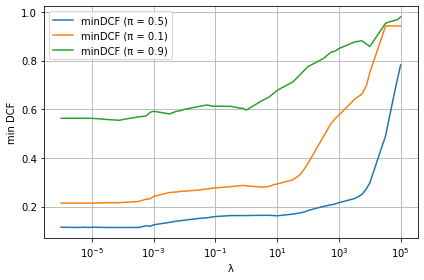

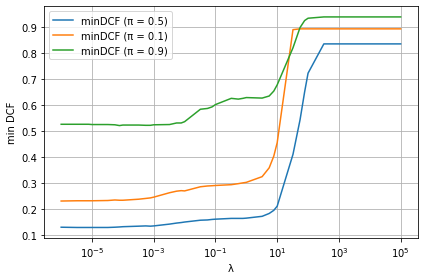

In [6]:
#######################################################################################
# Logistic Regression
#######################################################################################

classifier_name = numpy.array([
    "Log Reg"
])
classifiers = numpy.array([
    LogisticRegression
])
transformers = [
    [],
    [Gaussianizer]
]
transf_args = [
    [()],
    [()]
]
data = [DTR for i in range(2)]

lamb = numpy.array([10 ** i for i in range(-6, 6)])
lamb = numpy.array([numpy.linspace(lamb[i], lamb[i + 1], 5) for i in range(lamb.shape[0] - 1)]).reshape(-1)
priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[2]:
    mindcf = numpy.load('./data/training/minDCF_LogReg_lamb.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0], lamb.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[2]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0] * lamb.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        for k, l in enumerate(lamb):
                            future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p, (l,), transformers[d], transf_args[d])
                            future.add_done_callback(lambda _: progress.update())
                            results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d].min(axis=2, initial=inf)))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[2]:
    numpy.save('./data/training/minDCF_LogReg_lamb.npy', mindcf)

plot_mindcf(data, mindcf, priors, lamb, 'λ', store_computed_data[2], './plots/mindcf_training/LogReg_lamb_', ['Raw', 'Gaussianized'])

In [7]:
#######################################################################################
# Logistic Regression - λ = 0
#######################################################################################

lamb = 0
classifier_name = numpy.array([
    "Log Reg (λ = " + str(lamb) + ")",
    "Log Reg (λ = " + str(lamb) + ", π = 0.5)",
])
class_prior = [None, [0.5, 0.5]]
classifiers = numpy.array([
    LogisticRegression,
    LogisticRegression,
])
transformers = [
    [],
    [Gaussianizer],
]
transf_args = [
    [()],
    [()],
]
data = [DTR, DTR]

priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[3]:
    mindcf = numpy.load('./data/training/minDCF_LogReg_lamb_fixed.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[3]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p, (lamb, None, class_prior[i]), transformers[d],
                                                 transf_args[d])
                        future.add_done_callback(lambda _: progress.update())
                        results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d]))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[3]:
    numpy.save('./data/training/minDCF_LogReg_lamb_fixed.npy', mindcf)

╒══════════════════════════╤═══════╤═══════╤═══════╕
│                          │   0.5 │   0.1 │   0.9 │
╞══════════════════════════╪═══════╪═══════╪═══════╡
│ Log Reg (λ = 0)          │ 0.114 │ 0.214 │ 0.563 │
├──────────────────────────┼───────┼───────┼───────┤
│ Log Reg (λ = 0, π = 0.5) │ 0.117 │ 0.218 │ 0.526 │
╘══════════════════════════╧═══════╧═══════╧═══════╛
╒══════════════════════════╤═══════╤═══════╤═══════╕
│                          │   0.5 │   0.1 │   0.9 │
╞══════════════════════════╪═══════╪═══════╪═══════╡
│ Log Reg (λ = 0)          │ 0.129 │ 0.23  │ 0.526 │
├──────────────────────────┼───────┼───────┼───────┤
│ Log Reg (λ = 0, π = 0.5) │ 0.124 │ 0.234 │ 0.518 │
╘══════════════════════════╧═══════╧═══════╧═══════╛


╒═════════════════════════════════╤═══════╤═══════╤═══════╕
│                                 │   0.5 │   0.1 │   0.9 │
╞═════════════════════════════════╪═══════╪═══════╪═══════╡
│ Linear SVM (no class balancing) │ 0.187 │ 0.283 │ 0.682 │
├─────────────────────────────────┼───────┼───────┼───────┤
│ Linear SVM (π = 0.5)            │ 0.154 │ 0.264 │ 0.633 │
╘═════════════════════════════════╧═══════╧═══════╧═══════╛


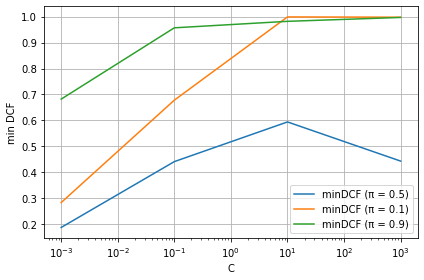

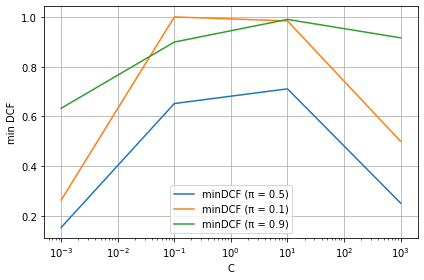

In [8]:
##################################################################################
# Linear SVM
##################################################################################

classifier_name = numpy.array([
    'Linear SVM (no class balancing)',
    'Linear SVM (π = 0.5)'
])
classifiers = numpy.array([
    LinearSVM,
    LinearSVM
])
transformers = [
    [],
]
transf_args = [
    [()],
]
data = [DTR]

Ci = numpy.array([10 ** i for i in range(-3, 4, 2)])
priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[4]:
    mindcf = numpy.load('./data/training/minDCF_LinearSVM_C.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0], Ci.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[4]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0] * Ci.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        for k, C in enumerate(Ci):
                            future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p, 
                                                     (1, C, 0.5 if i != 0 else None, None,),
                                                     transformers[d], transf_args[d])
                            future.add_done_callback(lambda _: progress.update())
                            results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d].min(axis=2, initial=inf)))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[4]:
    numpy.save('./data/training/minDCF_LinearSVM_C.npy', mindcf)

plot_mindcf(data, mindcf, priors, Ci, 'C', store_computed_data[4], './plots/mindcf_training/LinearSVM_C_', ['balanced', 'notBalanced'])


In [9]:
##################################################################################
# Linear SVM - C = 1e-3
##################################################################################

C = 1e-3  # chosen from previous step
classifier_name = numpy.array([
    'Linear SVM (no class balancing, C = ' + str(C) + ') ',
    'Linear SVM (π = 0.5, C = ' + str(C) + ')'
])
classifiers = numpy.array([
    LinearSVM,
    LinearSVM
])
transformers = [
    [],
]
transf_args = [
    [()],
]
data = [DTR]

priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[5]:
    mindcf = numpy.load('./data/training/minDCF_LinearSVM_C_fixed.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[5]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p,
                                                 (1, C, 0.5 if i != 0 else None, None,),
                                                 transformers[d], transf_args[d])
                        future.add_done_callback(lambda _: progress.update())
                        results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d]))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[5]:
    numpy.save('./data/training/minDCF_LinearSVM_C_fixed.npy', mindcf)

╒════════════════════════════════════════════╤═══════╤═══════╤═══════╕
│                                            │   0.5 │   0.1 │   0.9 │
╞════════════════════════════════════════════╪═══════╪═══════╪═══════╡
│ Linear SVM (no class balancing, C = 0.001) │ 0.187 │ 0.283 │ 0.682 │
├────────────────────────────────────────────┼───────┼───────┼───────┤
│ Linear SVM (π = 0.5, C = 0.001)            │ 0.154 │ 0.264 │ 0.633 │
╘════════════════════════════════════════════╧═══════╧═══════╧═══════╛


╒═══════════════════════════════════════════╤═══════╤═══════╤═══════╕
│                                           │   0.5 │   0.1 │   0.9 │
╞═══════════════════════════════════════════╪═══════╪═══════╪═══════╡
│ Quadratic Kernel SVM (no class balancing) │ 0.439 │ 0.967 │ 0.939 │
╘═══════════════════════════════════════════╧═══════╧═══════╧═══════╛


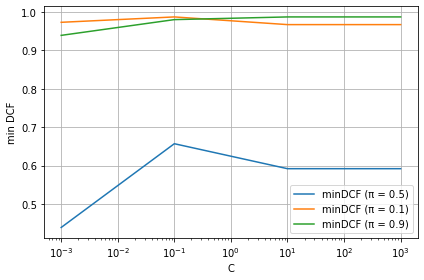

In [10]:
##################################################################################
# Quadratic kernel SVM
##################################################################################

classifier_name = numpy.array([
    'Quadratic Kernel SVM (no class balancing)'
])
classifiers = numpy.array([
    KernelSVM,
])
transformers = [
    [],
]
transf_args = [
    [()],
]
data = [DTR]

Ci = numpy.array([10 ** i for i in range(-3, 4, 2)])
priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[6]:
    mindcf = numpy.load('./data/training/minDCF_PolySVM_C.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0], Ci.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[6]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0] * Ci.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        for k, C in enumerate(Ci):
                            future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p,
                                                     (1, C, None, None, 'poly', (0, 2)),
                                                     transformers[d], transf_args[d])
                            future.add_done_callback(lambda _: progress.update())
                            results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d].min(axis=2, initial=inf)))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[6]:
    numpy.save('./data/training/minDCF_PolySVM_C.npy', mindcf)

plot_mindcf(data, mindcf, priors, Ci, 'C', store_computed_data[6], './plots/mindcf_training/PolySVM_C')

In [11]:
##################################################################################
# Quadratic kernel SVM - log(C) = -3
##################################################################################

C = 1e-3
classifier_name = numpy.array([
    'Quadratic Kernel SVM (π = 0.5, C = ' + str(C) + ')'
])
classifiers = numpy.array([
    KernelSVM,
])
transformers = [
    [],
]
transf_args = [
    [()],
]
data = [DTR]

priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[7]:
    mindcf = numpy.load('./data/training/minDCF_PolySVM_C_fixed.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[7]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p,
                                                 (1, C, 0.5, None, 'poly', (0, 2)),
                                                 transformers[d], transf_args[d])
                        future.add_done_callback(lambda _: progress.update())
                        results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d]))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[7]:
    numpy.save('./data/training/minDCF_PolySVM_C_fixed.npy', mindcf)

╒═══════════════════════════════════════════╤═══════╤═══════╤═══════╕
│                                           │   0.5 │   0.1 │   0.9 │
╞═══════════════════════════════════════════╪═══════╪═══════╪═══════╡
│ Quadratic Kernel SVM (π = 0.5, C = 0.001) │ 0.406 │ 0.726 │ 0.917 │
╘═══════════════════════════════════════════╧═══════╧═══════╧═══════╛


╒═════════════════════════════════════╤═════════════════╤═════════════════╤═════════════════╕
│                                     │   log(γ) = -4.0 │   log(γ) = -3.0 │   log(γ) = -2.0 │
╞═════════════════════════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ RBF Kernel SVM (no class balancing) │           0.125 │           0.143 │           0.184 │
╘═════════════════════════════════════╧═════════════════╧═════════════════╧═════════════════╛


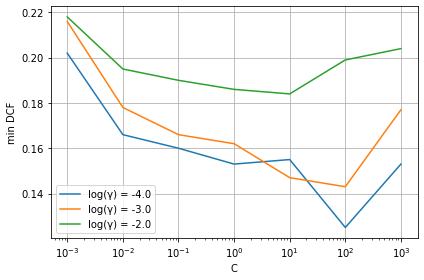

In [12]:
##################################################################################
# RBF kernel SVM
##################################################################################

classifier_name = numpy.array([
    'RBF Kernel SVM (no class balancing)'
])
classifiers = numpy.array([
    KernelSVM,
])
transformers = [
    [],
]
transf_args = [
    [()],
]
data = [DTR]

Ci = numpy.array([10 ** i for i in range(-3, 4)])
gamma_i = numpy.array([10 ** i for i in range(-4, -1)])
priors = numpy.array([0.5])

if load_precomputed_data[8]:
    mindcf = numpy.load('./data/training/minDCF_RBF_SVM_C_gamma.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0], gamma_i.shape[0], Ci.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[8]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0] * gamma_i.shape[0] * Ci.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        for g, gamma in enumerate(gamma_i):
                            for k, C in enumerate(Ci):
                                print(classifier_name[i] + ", π = " + str(p) + ", D = " + str(d) + ", log(γ) = " + str(numpy.log10(gamma)) + ", log(C) = " + str(numpy.log10(C)))
                                future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p,
                                                         (1, C, None, None, 'rbf', (gamma,)),
                                                         transformers[d], transf_args[d])
                                future.add_done_callback(lambda _: progress.update())
                                results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d, 0].min(axis=2, initial=inf)))
        print(tabulate(table, headers=[""] + ["log(γ) = " + str(numpy.log10(gamma)) for gamma in gamma_i], tablefmt='fancy_grid'))

if store_computed_data[8]:
    numpy.save('./data/training/minDCF_RBF_SVM_C_gamma.npy', mindcf)

for d in range(len(data)):
    for i in range(mindcf[d].shape[0]):
        plt.figure()
        for j, p in enumerate(priors):
            for g, gamma in enumerate(gamma_i):
                plt.plot(Ci, mindcf[d, i, j, g], label='log(γ) = ' + str(numpy.log10(gamma)))
        plt.xlabel('C')
        plt.ylabel('min DCF')
        plt.legend()
        plt.grid(True)
        plt.xscale('log')
        plt.tight_layout()
        if store_computed_data[8]:
            plt.savefig('./plots/mindcf_training/RBF_SVM_C_gamma.png')
        plt.show()

In [13]:
##################################################################################
# RBF kernel SVM - log(γ) = -4, log(C) = 2
##################################################################################

C = 1e2
gamma = 1e-4
classifier_name = numpy.array([
    'RBF Kernel SVM (no class balancing)',
    'RBF Kernel SVM (π = 0.5, log(C) = ' + str(numpy.log10(C)) + ', log(γ) = ' + str(numpy.log10(gamma)) + ')',
    'RBF Kernel SVM (π = 0.1, log(C) = ' + str(numpy.log10(C)) + ', log(γ) = ' + str(numpy.log10(gamma)) + ')',
    'RBF Kernel SVM (π = 0.9, log(C) = ' + str(numpy.log10(C)) + ', log(γ) = ' + str(numpy.log10(gamma)) + ')',
])
classifiers = numpy.array([
    KernelSVM,
    KernelSVM,
    KernelSVM,
    KernelSVM,
])
transformers = [
    [], [Gaussianizer]
]
transf_args = [
    [()], [()],
]
data = [DTR, DTR]

priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[9]:
    mindcf = numpy.load('./data/training/minDCF_RBF_SVM_C_gamma_fixed.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[9]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + ", π = " + str(p) + ", D = " + str(d) + ", log(γ) = " + str(numpy.log10(gamma)) + ", log(C) = " + str(numpy.log10(C)))
                        future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p,
                                                 (1, C, priors[i - 1] if i > 0 else None, None, 'rbf', (gamma,)),
                                                 transformers[d], transf_args[d])
                        future.add_done_callback(lambda _: progress.update())
                        results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d]))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[9]:
    numpy.save('./data/training/minDCF_RBF_SVM_C_gamma_fixed.npy', mindcf)

╒═══════════════════════════════════════════════════════╤═══════╤═══════╤═══════╕
│                                                       │   0.5 │   0.1 │   0.9 │
╞═══════════════════════════════════════════════════════╪═══════╪═══════╪═══════╡
│ RBF Kernel SVM (no class balancing)                   │ 0.125 │ 0.224 │ 0.829 │
├───────────────────────────────────────────────────────┼───────┼───────┼───────┤
│ RBF Kernel SVM (π = 0.5, log(C) = 2.0, log(γ) = -4.0) │ 0.141 │ 0.248 │ 0.629 │
├───────────────────────────────────────────────────────┼───────┼───────┼───────┤
│ RBF Kernel SVM (π = 0.1, log(C) = 2.0, log(γ) = -4.0) │ 0.12  │ 0.22  │ 0.81  │
├───────────────────────────────────────────────────────┼───────┼───────┼───────┤
│ RBF Kernel SVM (π = 0.9, log(C) = 2.0, log(γ) = -4.0) │ 0.192 │ 0.464 │ 0.611 │
╘═══════════════════════════════════════════════════════╧═══════╧═══════╧═══════╛
╒═══════════════════════════════════════════════════════╤═══════╤═══════╤═══════╕
│               

╒═══════════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│                   │     1 │     2 │     4 │     8 │    16 │    32 │    64 │
╞═══════════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ GMM Full cov      │ 0.141 │ 0.16  │ 0.145 │ 0.14  │ 0.14  │ 0.154 │ 0.203 │
├───────────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ GMM Diag cov      │ 0.141 │ 0.181 │ 0.194 │ 0.16  │ 0.157 │ 0.159 │ 0.168 │
├───────────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ GMM Tied Full cov │ 0.141 │ 0.141 │ 0.141 │ 0.157 │ 0.151 │ 0.15  │ 0.146 │
├───────────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ GMM Tied Diag cov │ 0.141 │ 0.181 │ 0.194 │ 0.16  │ 0.157 │ 0.159 │ 0.168 │
╘═══════════════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛
╒═══════════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│                   │     1 │     2 │     4 │     8 │    16 │   

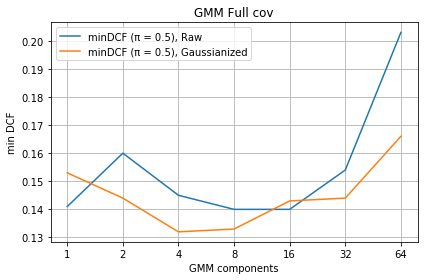

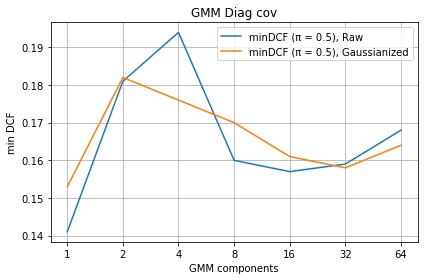

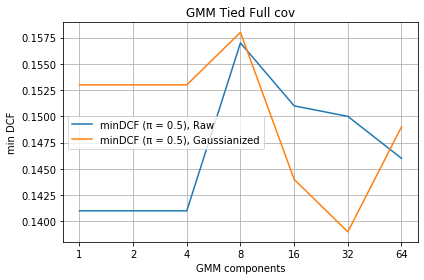

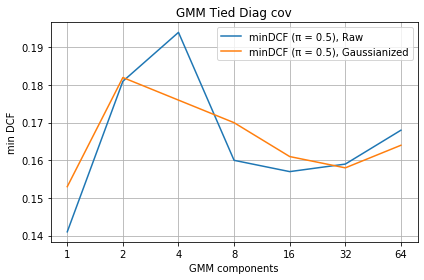

In [14]:
#######################################################################################
# GMM
#######################################################################################

classifier_name = numpy.array([
    'GMM Full cov',
    'GMM Diag cov',
    'GMM Tied Full cov',
    'GMM Tied Diag cov'
])
classifiers = numpy.array([
    GaussianMixtureModel,
    GaussianMixtureModel,
    GaussianMixtureModel,
    GaussianMixtureModel,
])
n_g_max = 64
n_g = numpy.array([2 ** i for i in range(int(numpy.log2(n_g_max)) + 1)])

prior = 0.5
data = [DTR, DTR]
mindcf = numpy.zeros((len(data), classifiers.shape[0], n_g.shape[0]))
transformers = [
    [],
    [Gaussianizer],
]
transf_args = [
    [()],
    [()],
]

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incorrect")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

if load_precomputed_data[10]:
    mindcf = numpy.load('./data/training/minDCF_GMM_n_g.npy')

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[10]:
            with tqdm(total=classifiers.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    print(classifier_name[i] + " - π = " + str(prior) + ", D = " + str(d))
                    class_args = tuple([True, True, n_g_max])
                    future = executor.submit(k_fold_GMM, D, LTR, 5, prior, [GaussianMixtureModel], class_args,
                                             transformers[d],
                                             transf_args[d], 'train')
                    future.add_done_callback(lambda _: progress.update())
                    results.append(future)
                for i, r in enumerate(results):
                    gmm_models = r.result()
                    for j, n_g_i in enumerate(n_g):
                        if mindcf[numpy.unravel_index(i * n_g.shape[0] + j, mindcf.shape, 'C')] == 0:
                            print(numpy.unravel_index(i * n_g.shape[0] + j, mindcf.shape, 'C'))
                            mindcf[numpy.unravel_index(i * n_g.shape[0] + j, mindcf.shape, 'C')] = round(k_fold_GMM(
                                D, LTR, 5, prior, gmm_models, (n_g_i,), transformers[d], transf_args[d]
                            ), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d, :].reshape(classifiers.shape[0], n_g.shape[0])))
        print(tabulate(table, headers=[""] + list(n_g), tablefmt='fancy_grid'))

if store_computed_data[10]:
    numpy.save('./data/training/minDCF_GMM_n_g' + classifier_name[0] + '_GAU.npy', mindcf)

for c in range(classifiers.shape[0]):
    plt.figure()
    for d in range(len(data)):
        name = 'Raw' if d == 0 else 'Gaussianized'
        plt.plot(numpy.log2(n_g), mindcf[d, c], label='minDCF (π = ' + str(prior) + '), ' + name)
        plt.xlabel('GMM components')
        plt.ylabel('min DCF')
        plt.legend()
        plt.grid(True)
        plt.title(classifier_name[c])
        plt.xticks(numpy.log2(n_g), n_g)
        plt.tight_layout()
        if store_computed_data[10]:
            plt.savefig('./plots/mindcf_training/GMM_' + classifier_name[c] + '_n_g.png')
    plt.show()

In [6]:
print("START")
llr_tied_full = k_fold_llr(DTR, LTR, 5, TiedCovarianceGaussianClassifier)
llr_LogReg = k_fold_llr(DTR, LTR, 5, LogisticRegression, class_args=(0,))
print("DONE")

START
DONE


100%|██████████| 8929/8929 [00:12<00:00, 700.74it/s]


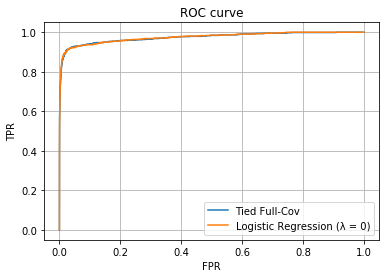

In [17]:
##################################################################
# Bayes error plots
##################################################################

scores_tied = numpy.sort(llr_tied_full)
FPR_arr_tied = []
TPR_arr_tied = []
for threshold in tqdm(scores_tied):
    predicted = 0 + (llr_tied_full > threshold)
    confusion_matrix_roc = compute_confusion_matrix(LTR, predicted)
    FNR = confusion_matrix_roc[0, 1] / sum(confusion_matrix_roc[:, 1])
    FPR = confusion_matrix_roc[1, 0] / sum(confusion_matrix_roc[:, 0])
    TPR = 1 - FNR
    FPR_arr_tied.append(FPR)
    TPR_arr_tied.append(TPR)

scores_logreg = numpy.sort(llr_LogReg)
FPR_arr_logreg = []
TPR_arr_logreg = []
for threshold in tqdm(scores_logreg):
    predicted = 0 + (llr_LogReg > threshold)
    confusion_matrix_roc = compute_confusion_matrix(LTR, predicted)
    FNR = confusion_matrix_roc[0, 1] / sum(confusion_matrix_roc[:, 1])
    FPR = confusion_matrix_roc[1, 0] / sum(confusion_matrix_roc[:, 0])
    TPR = 1 - FNR
    FPR_arr_logreg.append(FPR)
    TPR_arr_logreg.append(TPR)

plt.figure()
plt.grid(True)
plt.plot(FPR_arr_tied, TPR_arr_tied, label='Tied Full-Cov')
plt.plot(FPR_arr_logreg, TPR_arr_logreg, label='Logistic Regression (λ = 0)')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC curve')
plt.savefig('./plots/mindcf_training/ROC.png')
plt.show()


100%|██████████| 21/21 [08:41<00:00, 24.85s/it]


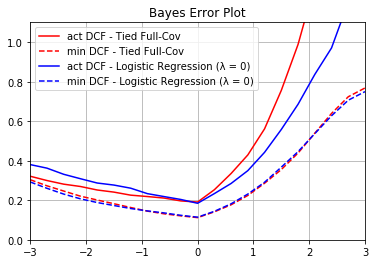

In [7]:
##################################################################
# Bayes error plots
##################################################################

effPriorLogOdds = numpy.linspace(-3, 3, 21)
p_arr = 1 / (1 + numpy.exp(-effPriorLogOdds))
dcf_tied = []
mindcf_tied = []
dcf_logreg = []
mindcf_logreg = []
for i in tqdm(range(len(p_arr))):
    predicted_tied = optimal_binary_bayes_decisions(p_arr[i], 1, 1, llr_tied_full)
    confusion_matrix = compute_confusion_matrix(LTR, predicted_tied)
    dcf_tied.append(DCF(p_arr[i], 1, 1, confusion_matrix))
    mindcf_tied.append(min_DCF(llr_tied_full, LTR, p_arr[i], 1, 1))

    predicted_logreg = optimal_binary_bayes_decisions(p_arr[i], 1, 1, llr_LogReg)
    confusion_matrix = compute_confusion_matrix(LTR, predicted_logreg)
    dcf_logreg.append(DCF(p_arr[i], 1, 1, confusion_matrix))
    mindcf_logreg.append(min_DCF(llr_LogReg, LTR, p_arr[i], 1, 1))

plt.figure()
plt.grid(True)
plt.plot(effPriorLogOdds, dcf_tied, label='act DCF - Tied Full-Cov', color='r')
plt.plot(effPriorLogOdds, mindcf_tied, label='min DCF - Tied Full-Cov', color='r', linestyle='dashed')
plt.plot(effPriorLogOdds, dcf_logreg, label='act DCF - Logistic Regression (λ = 0)', color='b')
plt.plot(effPriorLogOdds, mindcf_logreg, label='min DCF - Logistic Regression (λ = 0)', color='b', linestyle='dashed')
plt.legend()
plt.ylim([0, 1.1])
plt.xlim([-3, 3])
plt.title('Bayes Error Plot')
plt.savefig('./plots/mindcf_training/Bayes_error_plot.png')
plt.show()


100%|██████████| 21/21 [04:42<00:00, 13.47s/it]


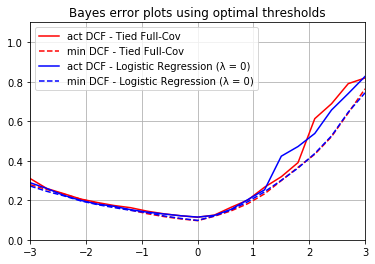

In [8]:
##################################################################
# Bayes error plots - Optimal threshold
##################################################################

effPriorLogOdds = numpy.linspace(-3, 3, 21)
p_arr = 1 / (1 + numpy.exp(-effPriorLogOdds))
dcf_tied = []
mindcf_tied = []
dcf_logreg = []
mindcf_logreg = []
for i in tqdm(range(len(p_arr))):
    mindcf, actdcf = optimal_threshold(llr_tied_full, LTR, p_arr[i])
    mindcf_tied.append(mindcf)
    dcf_tied.append(actdcf)

    mindcf, actdcf = optimal_threshold(llr_LogReg, LTR, p_arr[i])
    mindcf_logreg.append(mindcf)
    dcf_logreg.append(actdcf)

plt.figure()
plt.grid(True)
plt.plot(effPriorLogOdds, dcf_tied, label='act DCF - Tied Full-Cov', color='r')
plt.plot(effPriorLogOdds, mindcf_tied, label='min DCF - Tied Full-Cov', color='r', linestyle='dashed')
plt.plot(effPriorLogOdds, dcf_logreg, label='act DCF - Logistic Regression (λ = 0)', color='b')
plt.plot(effPriorLogOdds, mindcf_logreg, label='min DCF - Logistic Regression (λ = 0)', color='b', linestyle='dashed')
plt.legend()
plt.ylim([0, 1.1])
plt.xlim([-3, 3])
plt.title('Bayes error plots using optimal thresholds')
plt.savefig('./plots/mindcf_training/Bayes_error_plot_opt_thresholds.png')
plt.show()
